<a href="https://colab.research.google.com/github/Meet-Patel2580/Reinforcement_Learning/blob/main/Patel_Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from pylab import *

In [ ]:
# this class includes all the attributes and functions that define the environment 
class MeetEnv(object):
  def __init__(self, env_shape, nactions, env_type="edge_wrap"):
    self.shape    = env_shape    # tuple describing dimensions of environment (row, column)
    self.nstates  = self.shape[0]*self.shape[1]  
    self.nactions = nactions

    if env_type=="edge_wrap":
      self.T        = self.grid_transtion_edgeWrapping()
      self.R = self.set_reward_function()
    elif env_type=="static":
      self.T = self.grid_transtion()
      self.R = self.set_reward_function()
    elif env_type=="linear":
      self.T = self.linear_track_transition()
      self.R= self.set_reward_function()
    elif env_type=="cliff":
      self.T = self.grid_transtion_cliff_bottom()
      self.R= self.set_cliff_reward()
    else:
      raise Exception("not valid transition type (edge_wrap, static, linear are allowed)")

#checks to make sure all the probabilities for a certain action add up to 1
  def check_transition_prob(self, transition_matrix):
    action=0
    check= True
    for action in range(self.nactions):
      for state in range(self.nstates):
        sum=0
        for state2 in range(self.nstates):
          sum+=transition_matrix[state, state2, action]
          if state2==self.nstates-1:
            if "%.*f" % (1,sum)!= "%.*f" % (1,1):
              check=False
              break
    return check

#manually set transition function
  def set_transition_function(self):
    T = np.zeros((self.nstates,self.nstates,self.nactions))
    T[0,0,0] = 1
    T[0,1,1] = 0.6
    T[0,2,1] = 0.3
    T[0,3,1] = 0.1
    T[1,0,0] = 1
    T[1,2,1] = 1
    T[2,1,0] = 1
    T[2,3,1] = 1
    T[3,2,0] = 1
    T[3,3,1] = 1
    if self.check_transition_prob(T) == True:
      print(self.check_transition_prob(T))
      return T
    else:
      raise Exception("transition prob does not sum to 1 ")

#creates transition vector for a linear environment 
  def linear_track_transition(self):
    T = np.zeros((self.nstates,self.nstates,self.nactions))
    for action in range(self.nactions):
      if action == 0: # left
        for state in range(self.nstates):
          if state == 0:
            T[state,state,action] = 1
          else:
            T[state, state-1, action] = 1 
      elif action == 1: # right
        for state in range(self.nstates):
          if state == self.nstates-1:
            T[state, state, action] = 1
          else:
            T[state, state+1, action] = 1
    if self.check_transition_prob(T) == True:
      return T
    else:
      raise Exception("transition prob does not sum to 1 ") 

#creates transtion vector for regular grid environment 
  def grid_transtion(self):
    
    # initialize
    T = np.zeros((self.nstates, self.nstates, self.nactions))  # down, up, right, left

    # add neighbor connections and jumps, remove for endlines
    #T [starting_state, ending_state, action]
    T[list(range(0, self.nstates-self.shape[1])), list(range(self.shape[1],self.nstates)), 0] = 1     #down
    T[list(range(self.shape[1],self.nstates)),  list(range(0, self.nstates-self.shape[1])),1] = 1     # up
    T[list(range(0, self.nstates-1)),               list(range(1, self.nstates)),              2] = 1     # right
    T[list(range(1, self.nstates)),               list(range(0, self.nstates-1)),              3] = 1     # left

    #remove endlines
    T[list(range(self.shape[1]-1, self.nstates-1, self.shape[1])), list(range(self.shape[1], self.nstates, self.shape[1])),  2 ] = 0    # remove transitions from endlines on right action
    T[list(range(0,self.nstates-self.shape[1]+1, self.shape[1])) , list(range(-1,self.nstates-self.shape[1], self.shape[1])), 3] = 0    # remove transitions from endlines on left action
    # include self transitions 
    #T[start_state, end_state, action]
    T[list(range(self.nstates-self.shape[1],self.nstates)),list(range(self.nstates-self.shape[1], self.nstates)), 0] = 1
    T[list(range(self.shape[1])),list(range(self.shape[1])), 1] = 1    
    T[list(range(self.shape[1]-1, self.nstates, self.shape[1])), list(range(self.shape[1]-1, self.nstates, self.shape[1])),  2 ] = 1
    T[list(range(0,self.nstates-self.shape[1]+1, self.shape[1])) , list(range(0,self.nstates-self.shape[1]+1, self.shape[1])), 3] = 1

    if self.check_transition_prob(T) == True:
      return T
    else:
      raise Exception("transition prob does not sum to 1 ") 

#creates transition vector for edge-wrapping environment
  def grid_transtion_edgeWrapping(self):
    
    # initialize
    T = np.zeros((self.nstates, self.nstates, self.nactions))  # down, up, right, left

    # add neighbor connections and jumps, remove for endlines
    #T [starting_state, ending_state, action]
    T[list(range(0, self.nstates-self.shape[1])), list(range(self.shape[1],self.nstates)), 0] = 1     #down
    T[list(range(self.shape[1],self.nstates)),  list(range(0, self.nstates-self.shape[1])),1] = 1     # up
    T[list(range(0, self.nstates-1)),               list(range(1, self.nstates)),              2] = 1     # right
    T[list(range(1, self.nstates)),               list(range(0, self.nstates-1)),              3] = 1     # left

    #remove endlines
    T[list(range(self.shape[1]-1, self.nstates-1, self.shape[1])), list(range(self.shape[1], self.nstates, self.shape[1])),  2 ] = 0 # remove transitions from endlines on right action
    T[list(range(0,self.nstates-self.shape[1]+1, self.shape[1])) , list(range(-1,self.nstates-self.shape[1], self.shape[1])), 3] = 0 # remove transitions from endlines on left action
    
    #T[start_state, end_state, action]
    T[list(range(self.nstates-self.shape[1],self.nstates)),list(range(self.shape[1])), 0] = 1
    T[list(range(self.shape[1])),list(range(self.nstates-self.shape[1],self.nstates)), 1] = 1    
    T[list(range(self.shape[1]-1, self.nstates, self.shape[1])),list(range(0,self.nstates-self.shape[1]+1, self.shape[1])) ,  2 ] = 1 
    T[list(range(0,self.nstates-self.shape[1]+1, self.shape[1])) , list(range(self.shape[1]-1, self.nstates, self.shape[1])), 3] = 1
    
    if self.check_transition_prob(T) == True:
      return T
    else:
      raise Exception("transition prob does not sum to 1 ") 
  
#creates transition vector for cliff environment
  def grid_transtion_cliff_bottom(self):

    T = np.zeros((self.nstates, self.nstates, self.nactions))  # down, up, right, left

    # add neighbor connections and jumps, remove for endlines
    #T [starting_state, ending_state, action]
    T[list(range(0, self.nstates-2*self.shape[1])), list(range(self.shape[1],self.nstates-self.shape[1])), 0] = 1     #down
    T[list(range(self.shape[1],self.nstates)),  list(range(0, self.nstates-self.shape[1])),1] = 1     # up
    T[list(range(0, self.nstates-1)),               list(range(1, self.nstates)),              2] = 1     # right
    T[list(range(1, self.nstates)),               list(range(0, self.nstates-1)),              3] = 1     # left

    #remove endlines
    T[list(range(self.shape[1]-1, self.nstates-1, self.shape[1])), list(range(self.shape[1], self.nstates, self.shape[1])),  2 ] = 0    # remove transitions from endlines on right action
    T[list(range(0,self.nstates-self.shape[1]+1, self.shape[1])) , list(range(-1,self.nstates-self.shape[1], self.shape[1])), 3] = 0    # remove transitions from endlines on left action
    # include self transitions 
    #T[start_state, end_state, action]
    T[list(range(self.nstates-self.shape[1],self.nstates)),list(range(self.nstates-self.shape[1], self.nstates)), 0] = 1
    T[list(range(self.shape[1])),list(range(self.shape[1])), 1] = 1    
    T[list(range(self.shape[1]-1, self.nstates, self.shape[1])), list(range(self.shape[1]-1, self.nstates, self.shape[1])),  2 ] = 1
    T[list(range(0,self.nstates-self.shape[1]+1, self.shape[1])) , list(range(0,self.nstates-self.shape[1]+1, self.shape[1])), 3] = 1

    #moving into the cliff states, takes agent back to start 
    T[list(range((self.shape[1]*(self.shape[0]-2))+1,(self.shape[1]*(self.shape[0]-1))-1)), self.nstates-self.shape[1], 0] = 1 #when taking down action from states above cliff states
    T[(self.shape[1]*(self.shape[0]-2)),self.nstates-self.shape[1], 0]=1
    T[(self.shape[1]*(self.shape[0]-1))-1,self.nstates-1, 0]=1
    T[self.nstates-self.shape[1], self.nstates-self.shape[1]+1, 2] = 0
    T[self.nstates-self.shape[1], self.nstates-self.shape[1], 2] = 1 #from the left of cliff states
    T[self.nstates-1, self.nstates-2, 3] = 0
    T[self.nstates-1, self.nstates-self.shape[1], 3] = 1 #from the right of cliff states

    if self.check_transition_prob(T) == True:
      return T
    else:
      raise Exception("transition prob does not sum to 1 ") 
  
#creates reward vector for the cliff evironment where all cliff states are worth -100 and terminal state is 100
  def set_cliff_reward(self):
    R=np.ones((self.nstates,1))*-1
    R[-1] = 100
    R[list(range((self.shape[1]*(self.shape[0]-2))+1,(self.shape[1]*(self.shape[0]-1))-1))] = -100
    return R

#creates reward vector for grid environments where each state is worth -1, except the terminal state which is worth 100  
  def set_reward_function(self):
    R = np.ones((self.nstates, 1))*-1
    R[-1] = 100
    return R 

#moves agent when the current state and selected action are passed through, returns the next state with its rewards and boolean value of whether terminal state has been reached
  def move(self, current_state, selected_action):
    done=False
    probabilities = self.T[current_state, : ,selected_action]
    next_state = np.random.choice(np.arange(self.nstates), p=probabilities)
    reward=self.R[next_state,0]

    if reward != -1:
      done=True

    return next_state, reward, done

In [ ]:
#Q-agent class
class Qagent(object):
  def __init__(self, action_type, env, learning_rate=0.1, discount=0.95, epsilon=0):
    self.action_space= np.arange(env.nactions)
    self.action_t=action_type
    self.q_table = np.random.uniform(low=-2, high=0, size=(env.nstates, env.nactions))
    
    self.EPSILON=epsilon
    self.LEARNING_RATE=learning_rate
    self.DISCOUNT=discount

    if self.action_t=="random":
      self.choose_action=self.choose_random_action
    elif self.action_t=="max_value":
      self.choose_action=self.choose_max_value_action
    elif self.action_t=="with_epsilon":
      self.choose_action=self.choose_epsilon_action
    else:
      raise Exception("not valid action type")

#choosing random action
  def choose_random_action(self, state):
    a=np.random.choice(self.action_space)
    return a
#choosing action of max value
  def choose_max_value_action(self, state):
    action= np.argmax(self.q_table[state,:])
    return action
#choosing action of max value with an epsilon factor as well 
  def choose_epsilon_action(self, state):
    if np.random.random()>self.EPSILON:
        action = np.argmax(self.q_table[state])
    else:
        action=np.random.choice(self.action_space)
    return action

#updates q values in the q table after each step
  def q_update(self, current_state, current_action, reward, new_state):
    current_q = self.q_table[ current_state, current_action]
    max_future_q = np.max(self.q_table[new_state,:])
    
    new_q = (1-self.LEARNING_RATE)*current_q + self.LEARNING_RATE*(reward + self.DISCOUNT*max_future_q)
    self.q_table[current_state, current_action] = new_q

#SARSA agent class
class SarsaAgent(Qagent):
  def __init__(self, action_type, env, learning_rate=0.1, discount=0.95, epsilon=0 ):
    super().__init__(action_type, env, learning_rate=learning_rate , discount=discount, epsilon=epsilon)

#updates q values after each step 
  def q_update(self,current_state, current_action, reward, next_state, next_action):
    current_q = self.q_table[ current_state, current_action]
    future_q = self.q_table[ next_state, next_action] # np.max(self.q_table[new_state,:])
    
    new_q = (1-self.LEARNING_RATE)*current_q + self.LEARNING_RATE*(reward + self.DISCOUNT*future_q)
    self.q_table[current_state, current_action] = new_q



In [ ]:
def sarsa_navigate(env, agent, num_episodes, random_start=False, start=0):
  if agent.EPSILON != 0:
    has_epsilon=True
    start_eps_decay = 1
    end_eps_decay = num_episodes//2
    epsilon_decay_value = agent.EPSILON/(end_eps_decay-start_eps_decay)
  else:
    has_epsilon=False
  reward_tracking=[]
  max_steps= 1000
  for episode in range(num_episodes):
    total_reward=0
    if random_start:
      state=np.random.choice(env.nstates)
    else:
      state=start
    action = agent.choose_action(state)
    #print(f"agent starts in state:{state}")
    for step in range(max_steps):
      next_state, reward, done = env.move(state, action)
      #print(f"state={state} action={action} next state={next_state} reward={reward} end={done}")
      total_reward+=reward
      if not done:
        next_action = agent.choose_action(next_state)
        agent.q_update(state, action, reward, next_state, next_action)
      else:
        agent.q_table[state, action] = 0
        break
      state=next_state
      action=next_action
    #print(total_reward)
    reward_tracking.append(total_reward)
    if has_epsilon:
      if end_eps_decay >= episode >= start_eps_decay:
        agent.EPSILON -= epsilon_decay_value
        #print(episode, agent.EPSILON)
  if has_epsilon:
    agent.EPSILON= (epsilon_decay_value*end_eps_decay)
    #print(agent.EPSILON)
  return reward_tracking


In [ ]:
def navigate(env, agent, num_episodes, random_start=False, start=0):
  if agent.EPSILON != 0:
    has_epsilon=True
    start_eps_decay = 1
    end_eps_decay = num_episodes//2
    epsilon_decay_value = agent.EPSILON/(end_eps_decay-start_eps_decay)
  else:
    has_epsilon=False
  reward_tracking=[]
  max_steps= 1000
  for episode in range(num_episodes):
    total_reward=0
    if random_start:
      state=np.random.choice(env.nstates)
    else:
      state=start
    #print(f"agent starts in state:{state}")
    for step in range(max_steps):
      action = agent.choose_action(state)
      next_state, reward, done = env.move(state, action)
      #print(f"state={state} action={action} next state={next_state} reward={reward} end={done}")
      total_reward+=reward
      if not done:
        agent.q_update(state, action, reward, next_state)
      else:
        agent.q_table[state, action] = 0
        break
      state=next_state
    #print(total_reward)
    reward_tracking.append(total_reward)
    if has_epsilon:
      if end_eps_decay >= episode >= start_eps_decay:
        agent.EPSILON -= epsilon_decay_value
        #print(episode, agent.EPSILON)
  if has_epsilon:
    agent.EPSILON= (epsilon_decay_value*end_eps_decay)
    #print(agent.EPSILON)
  return reward_tracking


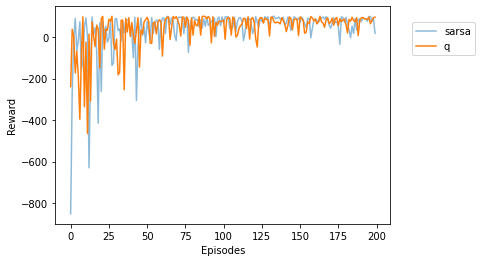

In [ ]:
#comparing sarsa to regular agent in a edge-wrap environment 
test_env= MeetEnv((20,20),4)
agent1=SarsaAgent("with_epsilon", test_env, learning_rate=0.9, epsilon=0.1)
agent2=Qagent("with_epsilon", test_env, learning_rate=0.9, epsilon=0.1)
num_e = 200
random_start=True
sarsa_performance=sarsa_navigate(test_env, agent1, num_e, random_start)
q_performance= navigate(test_env, agent2, num_e, random_start)

plt.plot(sarsa_performance, alpha=0.5, label="sarsa")
plt.plot(q_performance, label="q")
plt.legend(bbox_to_anchor=(1.05, 0.95))
plt.ylabel("Reward")
plt.xlabel("Episodes")
plt.show()

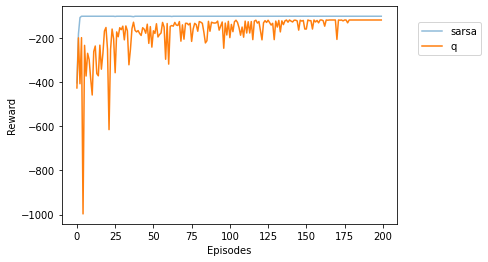

In [ ]:
#comparing sarsa and regular agent in a cliff environment
test_env= MeetEnv((20,20),4,"cliff")
agent1=SarsaAgent("with_epsilon", test_env, learning_rate=0.9, epsilon=0.1)
agent2=Qagent("with_epsilon", test_env, learning_rate=0.9, epsilon=0.1)
num_e = 200
random_start=False
sarsa_performance=sarsa_navigate(test_env, agent1, num_e, random_start,test_env.nstates-test_env.shape[1])
q_performance= navigate(test_env, agent2, num_e, random_start)

plt.plot(sarsa_performance, alpha=0.5, label="sarsa")
plt.plot(q_performance, label="q")
plt.legend(bbox_to_anchor=(1.05, 0.95))
plt.ylabel("Reward")
plt.xlabel("Episodes")
plt.show()

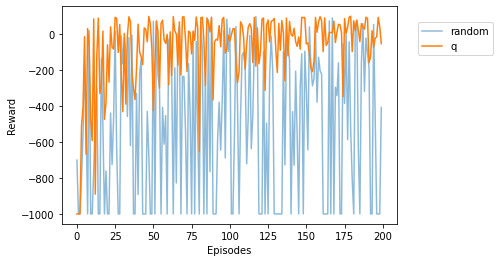

In [ ]:
#comparing q-learner to random agent 
test_env= MeetEnv((20,20),4)
agent1=agent("max_value", test_env)
agent2=agent("random", test_env,0,0,0)
num_e = 200
random_start=True
random_performance=navigate(test_env, agent2, num_e, random_start)
q_performance= navigate(test_env, agent1, num_e, random_start)

plt.plot(random_performance, alpha=0.5, label="random")
plt.plot(q_performance, label="q")
plt.legend(bbox_to_anchor=(1.05, 0.95))
plt.ylabel("Reward")
plt.xlabel("Episodes")
plt.show()

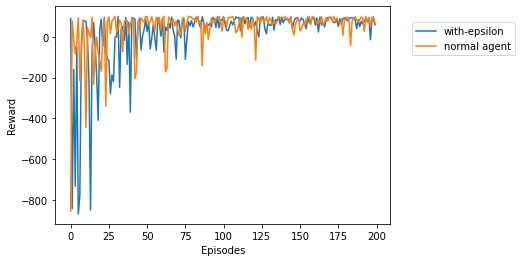

In [ ]:
#comparing normal q-learner to q-learner with epsilon 
test_env= MeetEnv((20,20),4)
agent1=agent("max_value", test_env, 0.9)
agent2=agent("with_epsilon", test_env,0.9, epsilon=0.9)
num_e = 200
random_start=True
q_performance=navigate(test_env, agent1, num_e, random_start)
q_with_epsilon= navigate(test_env, agent2, num_e, random_start)

plt.plot(q_with_epsilon, label="with-epsilon")
plt.plot(q_performance,label="normal agent")
plt.legend(bbox_to_anchor=(1.05, 0.95))
plt.ylabel("Reward")
plt.xlabel("Episodes")
plt.show()

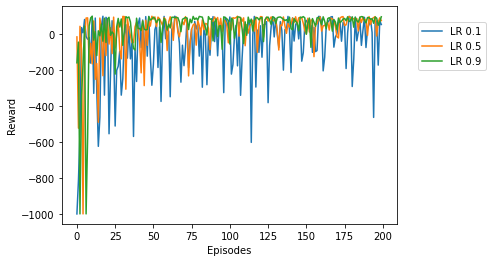

In [ ]:
#comparing learning rates
test_env= MeetEnv((20,20),4)
agent1=agent("max_value", test_env, 0.1)
agent2=agent("max_value", test_env, 0.5)
agent3=agent("max_value", test_env, 0.9)
num_e = 200
random_start=True
rate1=navigate(test_env, agent1, num_e, random_start)
rate2= navigate(test_env, agent2, num_e, random_start)
rate3= navigate(test_env, agent3, num_e, random_start)

plt.plot(rate1, label=f"LR {agent1.LEARNING_RATE}")
plt.plot(rate2, label=f"LR {agent2.LEARNING_RATE}")
plt.plot(rate3, label=f"LR {agent3.LEARNING_RATE}")
plt.legend(bbox_to_anchor=(1.05, 0.95))
plt.ylabel("Reward")
plt.xlabel("Episodes")
plt.show()


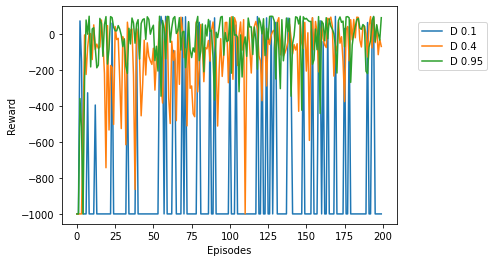

In [ ]:
#comparing discount
test_env= MeetEnv((20,20),4)
agent1=agent("max_value", test_env, 0.1, 0.1)
agent2=agent("max_value", test_env, 0.1, 0.4)
agent3=agent("max_value", test_env, 0.1, 0.95)
num_e = 200
random_start=True
rate1=navigate(test_env, agent1, num_e, random_start)
rate2= navigate(test_env, agent2, num_e, random_start)
rate3= navigate(test_env, agent3, num_e, random_start)

plt.plot(rate1, label=f"D {agent1.DISCOUNT}")
plt.plot(rate2, label=f"D {agent2.DISCOUNT}")
plt.plot(rate3, label=f"D {agent3.DISCOUNT}")
plt.legend(bbox_to_anchor=(1.05, 0.95))
plt.ylabel("Reward")
plt.xlabel("Episodes")
plt.show()


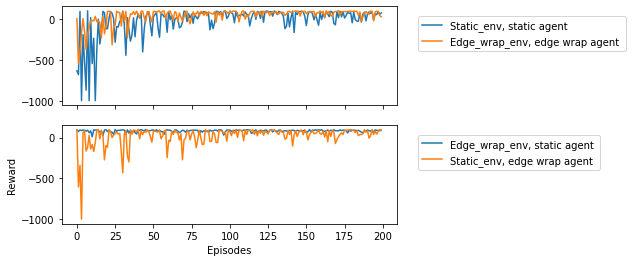

In [ ]:
#introducing trained agents to a new environment
edge_wrap_env=MeetEnv((20,20),4,"edge_wrap")
static_env=MeetEnv((20,20),4, "static")

agent_static_grid=agent("max_value", static_env, 0.9, epsilon=0)
agent_edge_wrapping=agent("max_value", edge_wrap_env, 0.9, epsilon= 0.1)

num_e=200
a1=navigate(static_env,agent_static_grid,num_e, True)
a2=navigate(edge_wrap_env, agent_edge_wrapping ,num_e, True)

b1=navigate(edge_wrap_env,agent_static_grid,num_e, True)
b2=navigate(static_env,agent_edge_wrapping,num_e, True)

fig,ax=plt.subplots(2,1, sharex=True)
ax[0].plot(a1, label="Static_env, static agent")
ax[0].plot(a2, label="Edge_wrap_env, edge wrap agent ")
ax[1].plot(b1, label="Edge_wrap_env, static agent")
ax[1].plot(b2, label="Static_env, edge wrap agent ")
ax[0].legend(bbox_to_anchor=(1.05, 0.95))
ax[1].legend(bbox_to_anchor=(1.05, 0.95))
ax[1].set_ylabel("Reward")
ax[1].set_xlabel("Episodes")
plt.show()

In [ ]:
#prints out the most liekly action to be taken from each state by the agent according to the current training session
path=np.zeros((test_env.nstates))
for states in range(test_env.nstates):
    max=-1000
    for actions in range(test_env.nactions):
      if agent2.q_table[states, actions]>max:
        max=agent2.q_table[states, actions]
        max_action=actions
    path[states]=max_action



In [ ]:
print(path)

[0. 3. 0. 3. 3. 0. 0. 0. 2. 2. 2. 0. 0. 0. 1. 0. 3. 1. 2. 3. 0. 2. 2. 3.
 0.]


In [ ]:
def one_D(shape, state):
  return(int(state/shape[1]), np.mod(state, shape[1]))

In [ ]:
print(one_D((20,20),21))

(1, 1)


In [ ]:
pref_action=np.zeros((5,5))
for i, entry in enumerate(path):
    two_D= one_D(test_env.shape, i)
    pref_action[two_D] = entry
    

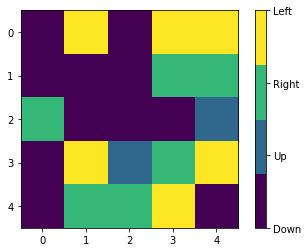

In [ ]:
plt.figure()
cmap=cm.get_cmap("viridis", 4)
a= plt.imshow(pref_action, cmap=cmap)

cbar=colorbar(a,ticks=[0,1,2,3])
cbar.ax.set_yticklabels(['Down','Up','Right','Left'])

plt.show()

In [ ]:
windyT = MeetEnv((1,10),2)
windyT.T[0,:,1] = [0.0, 0.5, 0.3, 0.1, 0.05, 0.05, 0, 0, 0, 0 ]
test_env=windyT

#windy test
agent1=agent("max_value", test_env, 0.05, 0.9)
agent2=agent("max_value", test_env, 0.05, 0.92)
agent3=agent("max_value", test_env, 0.05, 0.95)
num_e = 200
random_start=True
rate1=navigate(test_env, agent1, num_e, random_start)
rate2= navigate(test_env, agent2, num_e, random_start)
rate3= navigate(test_env, agent3, num_e, random_start)

plt.plot(rate1, label=f"D {agent1.DISCOUNT}")
plt.plot(rate2, label=f"D {agent2.DISCOUNT}")
plt.plot(rate3, label=f"D {agent3.DISCOUNT}")
plt.legend(bbox_to_anchor=(1.05, 0.95))
plt.ylabel("Reward")
plt.xlabel("Episodes")
plt.show()

In [ ]:
# finish move function to include done condition

# optional (play with stochastic probabilities in T matrix)

# until the done condition is met, visit states and collect rewards and print them out 

def printMoves(state):
  done=False
  
  if test_env.R[state,0]!=-1:
    done=True
    print("(",state,", ",test_env.R[state,0],", ", True,")" )

  while not done:
    action = agent1.choose_action(0)        #np.random.choice(np.arange(test_env.nactions))
    result=test_env.move(state, action) 
    print(f"state={state} action={action} next state={result[0]} reward={result[1]} end={result[2]}")
    new_state = result[0]
    reward = result[1] 
    done = result[2] 
    state = new_state


In [ ]:
printMoves(0)

In [ ]:
a = np.arange(10)
print(a)

In [ ]:
print(type(list(range(10))),type(a))


In [ ]:

sum=0
check= True
for action in range(test_env.nactions):
      for state in range(test_env.nstates):
        sum=0
        for state2 in range(test_env.nstates):
          print(test_env.T[state, state2, action])
          sum+=test_env.T[state, state2, action]
          if state2==test_env.nstates-1:
            print("sum",sum)
            if "%.*f" % (1,sum)!= "%.*f" % (1,1):
              check=False
              break
print(check)

In [ ]:
agent1=agent("max_value", test_env)
action=agent1.choose_action(0)
print(action)

In [ ]:
windyT = MeetEnv((1,4),2)
windyT[0,:,1] = [0.0, 0.6, 0.3, 0.1]
print(test_env.T)

In [ ]:
print(test_env.move(2,0))

In [ ]:
R = test_env.set_reward_function()
print(R)

In [ ]:
import gym 
import numpy as np
import matplotlib.pyplot as plt

# create environment
env = gym.make("MountainCar-v0")
env.reset()

# print min, max values for obs space
print(f'Min Obs = {env.observation_space.low}, Max Obs = {env.observation_space.high}')
print(f'Num Actions = {env.action_space.n}')

# # turn continuous observation space into discrete by binning
DISCRETE_OS_SIZE = [20] * len(env.observation_space.high)
discrete_os_window_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_OS_SIZE
print(discrete_os_window_size)

# make Q table
## TODO why did we pick [-2, 0]?
q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))
print(q_table.shape)

### PARAMETERS
EPISODES      = 25000
PRINTFREQ     = 2000

LEARNING_RATE = 0.1
DISCOUNT      = 0.95

EPSILON       = 0.5
start_eps_decay = 1
end_eps_decay = EPISODES//2
epsilon_decay_value = EPSILON/(end_eps_decay-start_eps_decay)

def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low) / discrete_os_window_size
    transformed_state = tuple(discrete_state.astype(np.int))
    return transformed_state

# test discrete state
state = env.reset()
discrete_state = get_discrete_state(state)
print(f'state {state} --> discrete state {discrete_state}')


ep_reward = []
agg_ep_rewards = {'ep': [], 'avg': [], 'min': [], 'max': []}

for ep in range(EPISODES):
    if ep%PRINTFREQ==0:
        print(ep)
        render = True
    else:
        render = False

    state = env.reset()
    discrete_state = get_discrete_state(state)
    done = False
    total_reward_per_ep = 0
    while not done:
        if np.random.random()>EPSILON:
            action = np.argmax(q_table[discrete_state])
        else:
            action = np.random.randint(0,env.action_space.n)
        new_state, reward, done, _ = env.step(action)
        total_reward_per_ep += reward
        new_discrete_state = get_discrete_state(new_state)
        if render:
            env.render()
        if not done:
            # update the table
            current_q    = q_table[discrete_state + (action, )]
            max_future_q = np.max(q_table[new_discrete_state])

            new_q = (1-LEARNING_RATE)*current_q + LEARNING_RATE*(reward + DISCOUNT*max_future_q)
            q_table[discrete_state+(action,)] = new_q

        elif new_state[0] >= env.goal_position:
            q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state

    ep_reward.append(total_reward_per_ep)

    if end_eps_decay >= ep >= start_eps_decay:
        EPSILON -= epsilon_decay_value

    if ep%PRINTFREQ==0:
        average_reward = sum(ep_reward[-PRINTFREQ:])/len(ep_reward[-PRINTFREQ:])
        agg_ep_rewards['ep'].append(ep)
        agg_ep_rewards['avg'].append(average_reward)
        agg_ep_rewards['min'].append(min(ep_reward[-PRINTFREQ:]))
        agg_ep_rewards['max'].append(max(ep_reward[-PRINTFREQ:]))
        print(f'EP: {ep} avg: {average_reward}, min: {min(ep_reward[-PRINTFREQ:])}, max: {max(ep_reward[-PRINTFREQ:])}')

env.close()

fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(agg_ep_rewards['ep'], agg_ep_rewards['avg'], label='avg')
ax[0].plot(agg_ep_rewards['ep'], agg_ep_rewards['min'], label='min')
ax[0].plot(agg_ep_rewards['ep'], agg_ep_rewards['max'], label='max')
ax[0].legend(loc=0)
plt.show()
